In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, LinearSegmentedColormap, SymLogNorm, ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d, RegularGridInterpolator
from numpy.polynomial.legendre import leggauss
import sys
import os
import warnings
import h5py

helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib
import phys_const as pc
import quantities as quant

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
# set dpi to 200
mpl.rcParams['figure.dpi'] = 200

In [3]:
### From HELIOS ###

def read_opac_file(quant, name, type="premixed", read_grid_parameters=False):
    """ reads the opacity table file for an individual species """

    with h5py.File(name, "r") as opac_file:

        print("\nReading opacity file:", name)

        try:
            opac_k = [k for k in opac_file["kpoints"][:]]
        except KeyError:
            opac_k = [k for k in opac_file["opacities"][:]]

        if type == "premixed":
            # Rayleigh scattering cross-sections
            quant.opac_scat_cross = [c for c in opac_file["weighted Rayleigh cross-sections"][:]]

            # pre-tabulated mean molecular mass values (& convert from mu to mean mass)
            quant.opac_meanmass = [m * pc.AMU for m in opac_file["meanmolmass"][:]]

        if type == "premixed" or read_grid_parameters is True:

            # wavelength grid
            try:
                quant.opac_wave = [x for x in opac_file["center wavelengths"][:]]
            except KeyError:
                quant.opac_wave = [x for x in opac_file["wavelengths"][:]]
            quant.nbin = np.int32(len(quant.opac_wave))

            # Gaussian y-points
            try:
                quant.gauss_y = [y for y in opac_file["ypoints"][:]]
            except KeyError:
                quant.gauss_y = [0]
            quant.ny = np.int32(len(quant.gauss_y))

            # interface positions of the wavelength bins
            try:
                quant.opac_interwave = [i for i in opac_file["interface wavelengths"][:]]
            except KeyError:
                # quick and dirty way to get the lamda interface values
                quant.opac_interwave = []
                quant.opac_interwave.append(quant.opac_wave[0] - (quant.opac_wave[1] - quant.opac_wave[0]) / 2)
                for x in range(len(quant.opac_wave) - 1):
                    quant.opac_interwave.append((quant.opac_wave[x + 1] + quant.opac_wave[x]) / 2)
                quant.opac_interwave.append(quant.opac_wave[-1] + (quant.opac_wave[-1] - quant.opac_wave[-2]) / 2)

            # widths of the wavelength bins
            try:
                quant.opac_deltawave = [w for w in opac_file["wavelength width of bins"][:]]
            except KeyError:
                quant.opac_deltawave = []
                for x in range(len(quant.opac_interwave) - 1):
                    quant.opac_deltawave.append(quant.opac_interwave[x + 1] - quant.opac_interwave[x])

            # temperature grid
            quant.ktemp = [t for t in opac_file["temperatures"][:]]
            quant.ntemp = np.int32(len(quant.ktemp))

            # pressure grid
            quant.kpress = [p for p in opac_file["pressures"][:]]
            quant.npress = np.int32(len(quant.kpress))

    return opac_k


def calc_planck(lamda, temp):
    """ calculates the Planckian blackbody function at a given wavelength and temperature """

    term1 = 2 * pc.H * pc.C**2 / lamda**5

    term2 = np.exp(pc.H * pc.C / (lamda * pc.K_B * temp)) - 1

    result = term1 * 1 / term2

    return result


def interpolate_opac(quant, T, P, log=False):
    # T in K, P in bar
    # Convert P to dyn/cm^2 to match quant.kpress
    P = P * 1e6

    # Create interpolator for each wavelength and y-point combination
    opac_k = np.array(quant.opac_k).reshape(quant.ntemp, quant.npress, quant.nbin, quant.ny)
    
    # If log interpolation requested, convert to log space
    if log:
        opac_k = np.log10(opac_k)
    
    # Create points for temperature and pressure only
    points = (quant.ktemp, quant.kpress)
    
    result = np.zeros((quant.nbin, quant.ny))
    
    # Interpolate each wavelength and y-point combination separately
    for i in range(quant.nbin):
        for j in range(quant.ny):
            values = opac_k[:,:,i,j]
            interpolator = RegularGridInterpolator(points, values)
            result[i,j] = interpolator([[T, P]])[0]
    
    # If log interpolation was used, convert back to linear space
    if log:
        result = 10**result
    
    return result


In [9]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7]) # surface pressure in dyn/cm^2
Tints = np.array([50, 100, 150, 200, 250, 300, 350]) # internal temperature in K

CplusOs = np.array([1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1]) #, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.59, 1.0])

folder = '../output/EqCond+Remove/'
noCond = False
add_name = '' #'_aN=1e-2'

In [10]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None, noCond=False):
    if noCond:
        noCond = '_NoCond'
    else:
        noCond = ''

    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'Earth_P0={format_e_nums(loop_over)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'Earth_P0={format_e_nums(P0)}_Tint={loop_over}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}'
    else:
        raise ValueError('Invalid loop_over value')


def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, noCond=False, add=''):
        
    data_dict = {
        "inds": [],
        "PTs": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": [],
        "nHtots": [],
        "lambda": [],
        "contribution": [],
        "opacity": [],
        "convective": []
    }

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond)
        name = name + add
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    convergence_conditions = d[-1,2] != 1e-1
                    convergence_conditions = convergence_conditions and not np.all(d[:,0] == 1.001)
                    if convergence_conditions: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=0), dtype=int,  max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        if j == -1:
            d = np.zeros_like(d)
            d[:,:] = np.nan

            mu = np.zeros_like(mu)
            mu[:] = np.nan

            j = np.nan
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data_dict["data"].append(d)

            contrib = folder + name + '/' + name + '_contribution.dat'
            contrib = np.loadtxt(contrib, skiprows=2)
            lam = contrib[:, 1:4] # central, lower and delta lambda
            contrib = contrib[:, 4:]

            opacity = folder + name + '/' + name + '_opacities.dat'
            opacity = np.loadtxt(opacity, skiprows=3)
            opacity = opacity[:, 4:]

            convective = folder + name + f'/{name}_tp.dat'
            convective = np.loadtxt(convective, skiprows=2, usecols=6)

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False

        data_dict["PTs"].append(np.array([d[:, 2] * 1e-6, d[:, 0]]).T)  # convert pressure from dyn/cm^2 to bar
        data_dict["nHtots"].append(d[:, 1])
        data_dict["atoms"].append(d[:, 3:4+n_elem])
        data_dict["mols"].append(d[:, 4+n_elem:4+n_elem+n_mol])
        data_dict["supersats"].append(d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        data_dict["dusts"].append(d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        data_dict["eps_atoms"].append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_to_gas"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_vol"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1])

        data_dict["inds"].append(i)
        data_dict["mus"].append(mu)
        data_dict["convective"].append(convective)

        data_dict["lambda"].append(lam)
        data_dict["contribution"].append(contrib)
        data_dict["opacity"].append(opacity)

        data_dict["convergence"].append(conv)
    
    if not data_dict["inds"]:
        data_dict["inds"] = np.empty((1))
        data_dict["PTs"] = np.empty((1, 2))
        data_dict["nHtots"] = np.empty((1))
        data_dict["data"] = np.empty((1, 1, 4+n_elem+n_mol+n_dust+7))
        data_dict["atoms"] = np.empty((1, 1, n_elem))
        data_dict["mols"] = np.empty((1, 1, n_mol))
        data_dict["supersats"] = np.empty((1, 1, n_dust))
        data_dict["dusts"] = np.empty((1, 1, n_dust))
        data_dict["eps_atoms"] = np.empty((1, 1, n_elem))
        data_dict["dust_to_gas"] = np.empty((1, 1))
        data_dict["dust_vol"] = np.empty((1, 1))

    data_dict["inds"] = np.array(data_dict["inds"])
    data_dict["PTs"] = np.array(data_dict["PTs"])
    data_dict["nHtots"] = np.array(data_dict["nHtots"])
    data_dict["data"] = np.array(data_dict["data"])
    data_dict["atoms"] = np.array(data_dict["atoms"])
    data_dict["mols"] = np.array(data_dict["mols"])
    data_dict["supersats"] = np.array(data_dict["supersats"])
    data_dict["dusts"] = np.array(data_dict["dusts"])
    data_dict["eps_atoms"] = np.array(data_dict["eps_atoms"])
    data_dict["dust_to_gas"] = np.array(data_dict["dust_to_gas"])
    data_dict["dust_vol"] = np.array(data_dict["dust_vol"])
    data_dict["convergence"] = np.array(data_dict["convergence"])
    data_dict["mus"] = np.array(data_dict["mus"])
    data_dict["lambda"] = np.array(data_dict["lambda"])
    data_dict["contribution"] = np.array(data_dict["contribution"])
    data_dict["opacity"] = np.array(data_dict["opacity"])
    data_dict["convective"] = np.array(data_dict["convective"], dtype=bool)

    return name, data_dict

def convert(data_dict):

    for i in range(len(data_dict["data"])):
        n_tot = 10**data_dict["data"][i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        data_dict["ntots"].append(n_tot[:, None])
    data_dict["ntots"] = np.array(data_dict["ntots"])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(data_dict["atoms"]):
        atom = 10**atom
        data_dict["atoms"][i] = atom / data_dict["ntots"][i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(data_dict["mols"]):
        mol = 10**mol
        data_dict["mols"][i] = mol / data_dict["ntots"][i]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    for i in range(len(data_dict["dusts"])):
        data_dict["dusts"][i] = 10**(data_dict["dusts"][i]) * data_dict["nHtots"][i][:, None] / data_dict["ntots"][i]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict

In [15]:
i_P0 = 1 # i_param = 0
i_Tint = 1 # i_param = 1
i_CplusO = 2 # i_param = 2
i_CtoO = 1 # i_param = 3

loop_overs = np.array([0.59])

name, data_dict = extract_data(loop_overs, i_P0, i_Tint, i_CplusO, i_CtoO, add=add_name)
data_dict = convert(data_dict)

0.0 5.569061245538682


/tmp/ipykernel_129380/3922149294.py:7: RuntimeWarning: divide by zero encountered in log10
  show = np.log10(show)


(1.0, 1e-07)

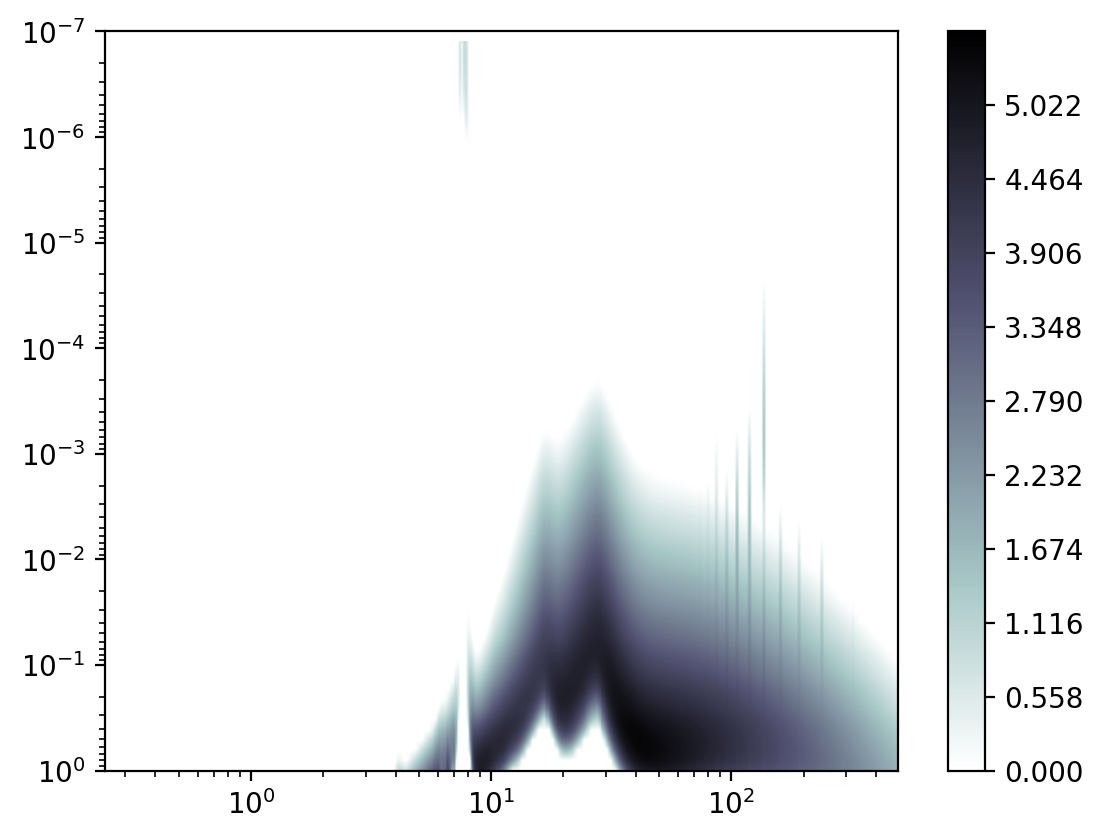

In [16]:
x, y = np.meshgrid(data_dict['lambda'][0,:,0], data_dict['PTs'][0,:-1,0])

print(np.min(data_dict['contribution'][0,:,:]), np.log10(np.max(data_dict['contribution'][0,:,:])))

vmin = 0
show = data_dict['contribution'][0,:,:].T
show = np.log10(show)
show[show < vmin] = vmin

cf = plt.contourf(x, y, show, 1000, cmap=plt.cm.bone_r, vmin=vmin)
plt.colorbar(cf)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0, 1e-7)

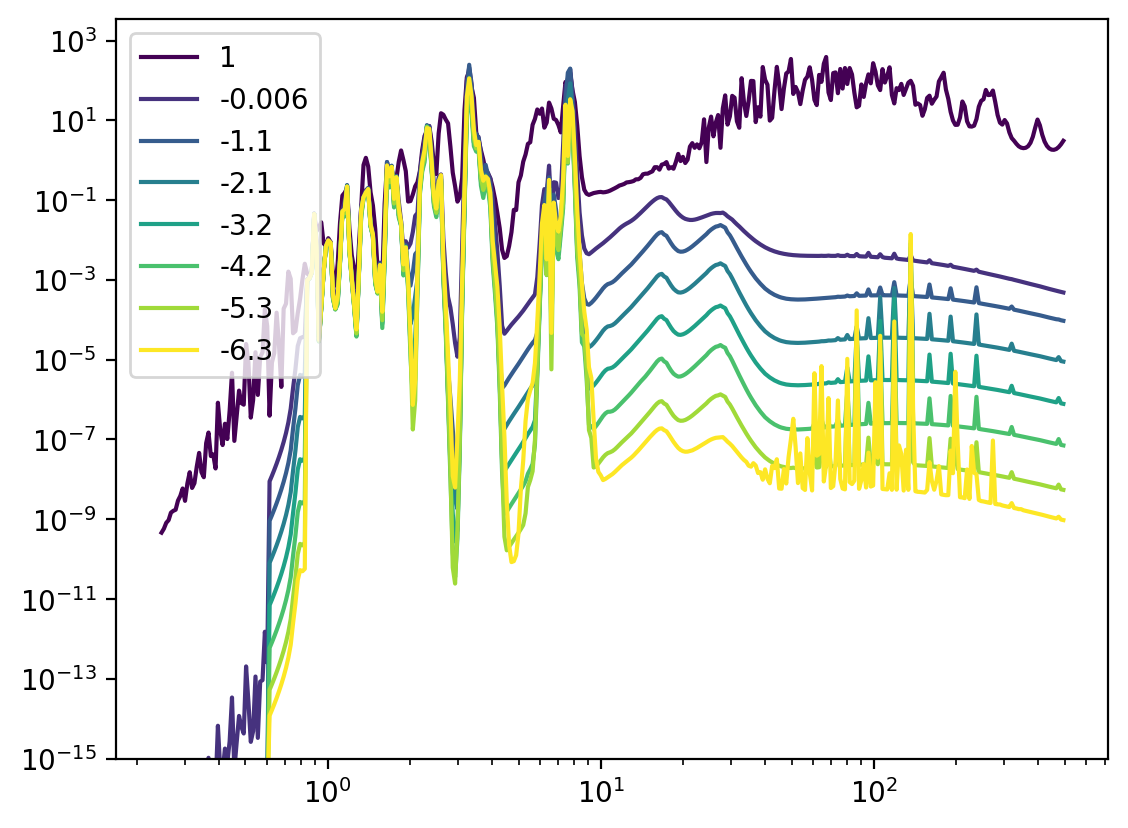

In [17]:
skip = 11
labels = [f'{np.log10(p):.2g}' for p in data_dict['PTs'][0,::skip,0]]

for i in range(len(labels)):
    plt.plot(data_dict['lambda'][0,:,0], data_dict['opacity'][0,:,::skip][:,i], label=labels[i], color=cmap(i/(len(labels)-1)))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-15, None)
plt.legend()

In [37]:
names = ['CIA_H2H2', 'CH4', 'H2O'] #, 'NH3']
cia = [True, False, False] #, False]
opac_path = '../../HELIOS/input/opacity/r50_kdistr/'

keepers = []

for i, name in enumerate(names):
    if name == 'scat_cross_sections':
        read_file = opac_path + name + '.h5'
    else:
        read_file = opac_path + name + '_opac_kdistr.h5'

    keeper = quant.Store()
    keeper.opac_k = read_opac_file(keeper, read_file, type='other', read_grid_parameters=True)

    keeper.opac_wave = np.array(keeper.opac_wave)
    keeper.opac_k = np.array(keeper.opac_k).reshape(keeper.ntemp, keeper.npress, keeper.nbin, keeper.ny)

    keeper.gauss_weight = leggauss(keeper.ny)[1]

    keepers.append(keeper)


Reading opacity file: ../../HELIOS/input/opacity/r50_kdistr/CIA_H2H2_opac_kdistr.h5

Reading opacity file: ../../HELIOS/input/opacity/r50_kdistr/CH4_opac_kdistr.h5

Reading opacity file: ../../HELIOS/input/opacity/r50_kdistr/H2O_opac_kdistr.h5


In [38]:
# interpolate opacity
layer = np.where(data_dict["convective"] == 0)[1][0] - 1 # radiative-convective boundary
T = data_dict['PTs'][0,layer,1]
P = data_dict['PTs'][0,layer,0]

mrs = np.array([data_dict['mols'][0,layer,mol_names == mol_name] for mol_name in ['H2' ,'CH4', 'H2O']])[:,0]
print(mrs)

opacs = []
opac_tot = np.zeros((keepers[0].nbin, keepers[0].ny))

for i, keeper in enumerate(keepers):
    if cia[i]:
        opac = interpolate_opac(keeper, T, P, log=False) * mrs[i]**2 # only works for CIA with itself
    else:
        opac = interpolate_opac(keeper, T, P, log=False) * mrs[i]
    opac_tot += opac
    #opac = np.sum(0.5 * keeper.gauss_weight * opac, axis=-1)
    opac = np.trapz(opac, x=keeper.gauss_y, axis=-1)
    opacs.append(opac)

#opac_tot = np.sum(0.5 * keepers[0].gauss_weight * opac_tot, axis=-1)
opac_tot = np.trapz(opac_tot, x=keepers[0].gauss_y, axis=-1)

[9.92349082e-01 7.65091844e-03 7.64217137e-18]


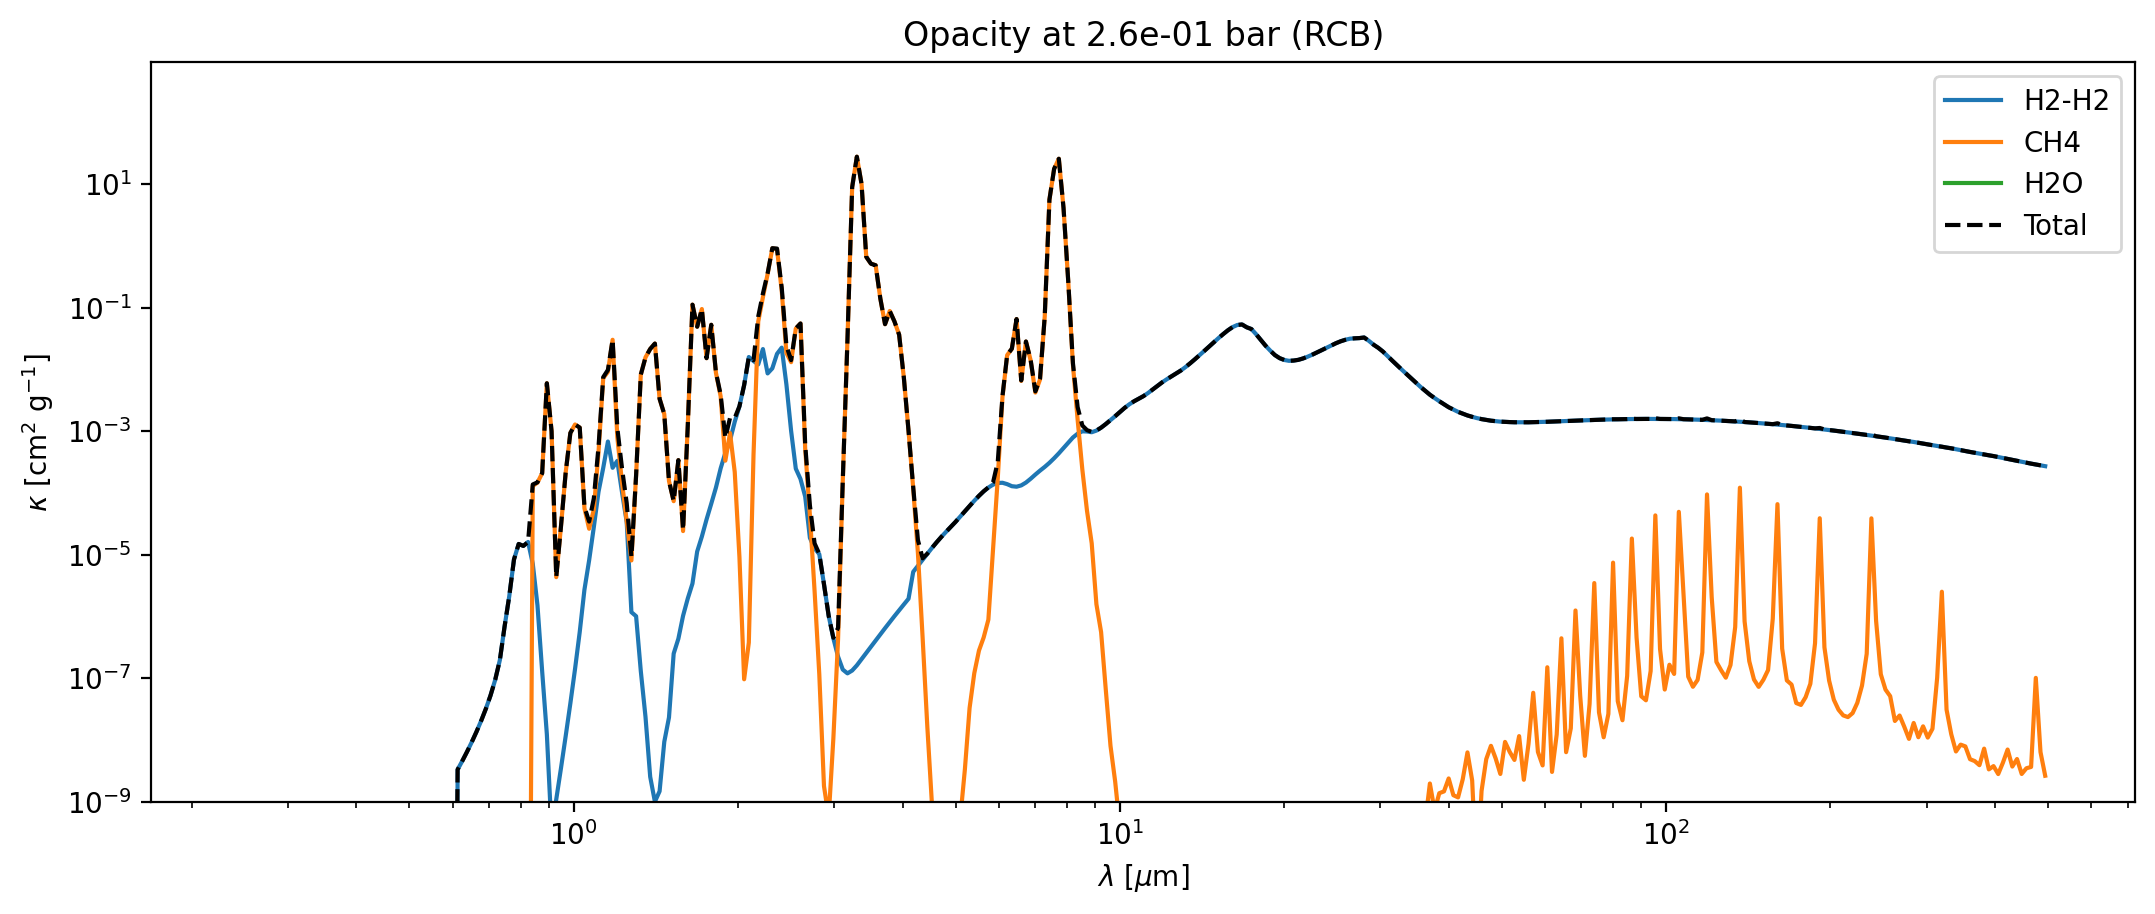

In [53]:
label = f'logP = {np.log10(data_dict['PTs'][0,layer,0]):.2g}'

plt.figure(figsize=(12.8, 4.8))
#plt.plot(data_dict['lambda'][0,:,0], data_dict['opacity'][0,:,layer]*10, label=label)

plt.plot(keepers[0].opac_wave*1e4, opacs[0], label='H2-H2')
plt.plot(keepers[1].opac_wave*1e4, opacs[1], label='CH4')
plt.plot(keepers[2].opac_wave*1e4, opacs[2], label='H2O')
#plt.plot(keepers[3].opac_wave*1e4, opacs[3], label='NH3')

plt.plot(keepers[0].opac_wave*1e4, opac_tot, '--', label='Total', color='black')

#plt.plot(data_dict['lambda'][0,:,0], data_dict['opacity'][0,:,layer], '--', label=label, color='black')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9, None)

plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'$\kappa$ [cm$^2$ g$^{-1}$]')
plt.title(f'Opacity at {P:.1e} bar (RCB)')
plt.legend()

295.976


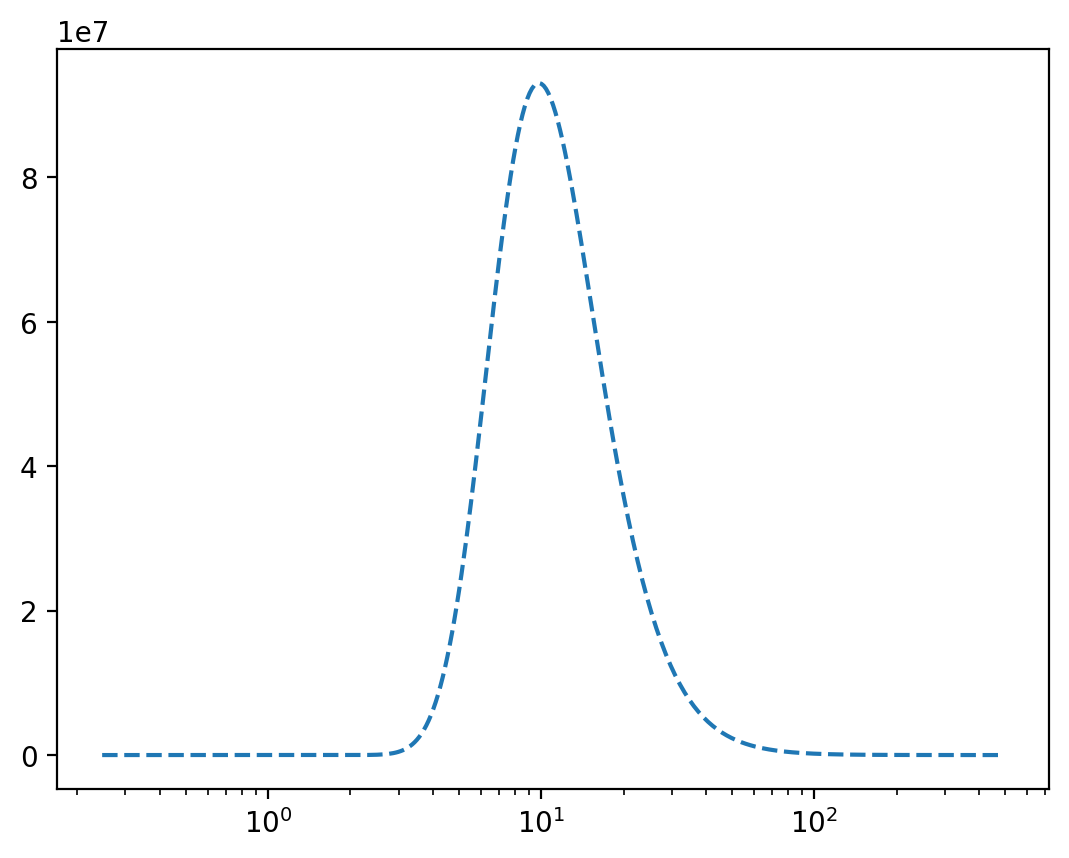

In [21]:
# plot planck function
print(T)
planck = calc_planck(data_dict['lambda'][0,:,0]*1e-4, T)
plt.plot(data_dict['lambda'][0,:,0], planck, '--', label='Planck')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-9, None)